/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBerta-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Step 1: Training only rho...
Epoch 1, Train Loss: 0.8407, Val Loss: 0.5378
Epoch 2, Train Loss: 0.4513, Val Loss: 0.1165
Epoch 3, Train Loss: 0.2603, Val Loss: 0.2155
Epoch 4, Train Loss: 0.2262, Val Loss: 0.0978
Epoch 5, Train Loss: 0.1978, Val Loss: 0.0913
Epoch 6, Train Loss: 0.2069, Val Loss: 0.0765
Epoch 7, Train Loss: 0.1919, Val Loss: 0.0810
Epoch 8, Train Loss: 0.1794, Val Loss: 0.0825
Epoch 9, Train Loss: 0.1763, Val Loss: 0.0725
Epoch 10, Train Loss: 0.1797, Val Loss: 0.0702
Epoch 11, Train Loss: 0.1087, Val Loss: 0.0664
Epoch 12, Train Loss: 0.1658, Val Loss: 0.0661
Epoch 13, Train Loss: 0.1771, Val Loss: 0.0686
Epoch 14, Train Loss: 0.1635, Val Loss: 0.0617
Epoch 15, Train Loss: 0.1000, Val Loss: 0.0612
Epoch 16, Train Loss: 0.1749, Val Loss: 0.0633
Epoch 17, Train Loss: 0.1744, Val Loss: 0.0650
Epoch 18, Train Loss: 0.1770, Val Loss: 0.0620
Epoch 19, Train Loss: 0.1662, Val Loss: 0.0620
Epoch 20, Train Loss: 0.1715, Val Loss: 0.0601
Epoch 21, Train Loss: 0.1631, Val Loss

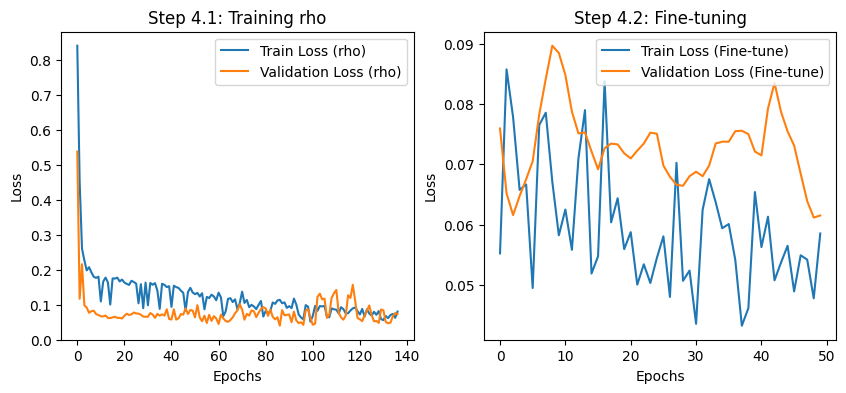

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from transformers import AutoTokenizer, AutoModel
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 1: Load dataset
class SMILESDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        smiles_1 = self.df.loc[idx, 'SMILES_part1']
        smiles_2 = self.df.loc[idx, 'SMILES_part2']
        target = self.df.loc[idx, ['BetaT', 'GammaT', 'BetaV', 'GammaV','Fij']]
        return (smiles_1, smiles_2), torch.tensor(target, dtype=torch.float32)

# Step 2: ChemBerta Encoder
class ChemBertaEncoder(nn.Module):
    def __init__(self, pretrained_model='DeepChem/ChemBerta-77M-MLM'):
        super().__init__()
        self.model = AutoModel.from_pretrained(pretrained_model)
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

    def forward(self, smiles_list):
        tokens = self.tokenizer(
            smiles_list,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

        outputs = self.model(**tokens)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Extract CLS token
        return embeddings

# Step 3: DeepSet model
class DeepSet(nn.Module):
    def __init__(self, embedding_dim=384, output_dim=5):
        super().__init__()
        self.phi = ChemBertaEncoder()

        self.rho = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, smiles_pairs):
        smiles_1, smiles_2 = smiles_pairs
        emb1 = self.phi(smiles_1)
        emb2 = self.phi(smiles_2)

        agg_emb = emb1 + emb2  # Sum aggregation
        return self.rho(agg_emb)

# Step 4: Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NEDO/REFPROP_Material property/deepset-bi-mixtures/src/20250401_deepsetInPytorch_KW0/model/sum/split_smiles.csv')

# Splitting into Train (80%), Validation (10%), Test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = SMILESDataset(train_df)
val_dataset = SMILESDataset(val_df)
test_dataset = SMILESDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

model = DeepSet().to(device)
criterion = nn.MSELoss()

# Step 4.1: Train only rho
for param in model.phi.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Early Stopping Parameters
patience = 50
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

print('\n Step 1: Training only rho...')
for epoch in range(1000):
    total_train_loss = 0
    model.train()
    for smiles_pairs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(smiles_pairs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation Loss Calculation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for smiles_pairs, targets in val_loader:
            predictions = model(smiles_pairs)
            loss = criterion(predictions, targets)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # Save best model state
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break  # Stop training

# Load best model state
if best_model_state:
    model.load_state_dict(best_model_state)

# Step 4.2: Fine-tune entire model
for param in model.phi.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Reset patience
patience_counter = 0
patience = 50
fine_tune_train_losses = []
fine_tune_val_losses = []

# fine-tuning loop
print('\n Step 2: Fine-tuning the entire model...')
for epoch in range(100):
    total_train_loss = 0
    model.train()
    for smiles_pairs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(smiles_pairs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation loss calculation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for smiles_pairs, targets in val_loader:
            predictions = model(smiles_pairs)
            loss = criterion(predictions, targets)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    fine_tune_train_losses.append(avg_train_loss)
    fine_tune_val_losses.append(avg_val_loss)

    print(f'Fine-tune Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break  # Stop training

# Load best model state
if best_model_state:
    model.load_state_dict(best_model_state)

# Plot Separate Loss Curves
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (rho)')
plt.plot(val_losses, label='Validation Loss (rho)')
plt.title('Step 4.1: Training rho')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_train_losses, label='Train Loss (Fine-tune)')
plt.plot(fine_tune_val_losses, label='Validation Loss (Fine-tune)')
plt.title('Step 4.2: Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



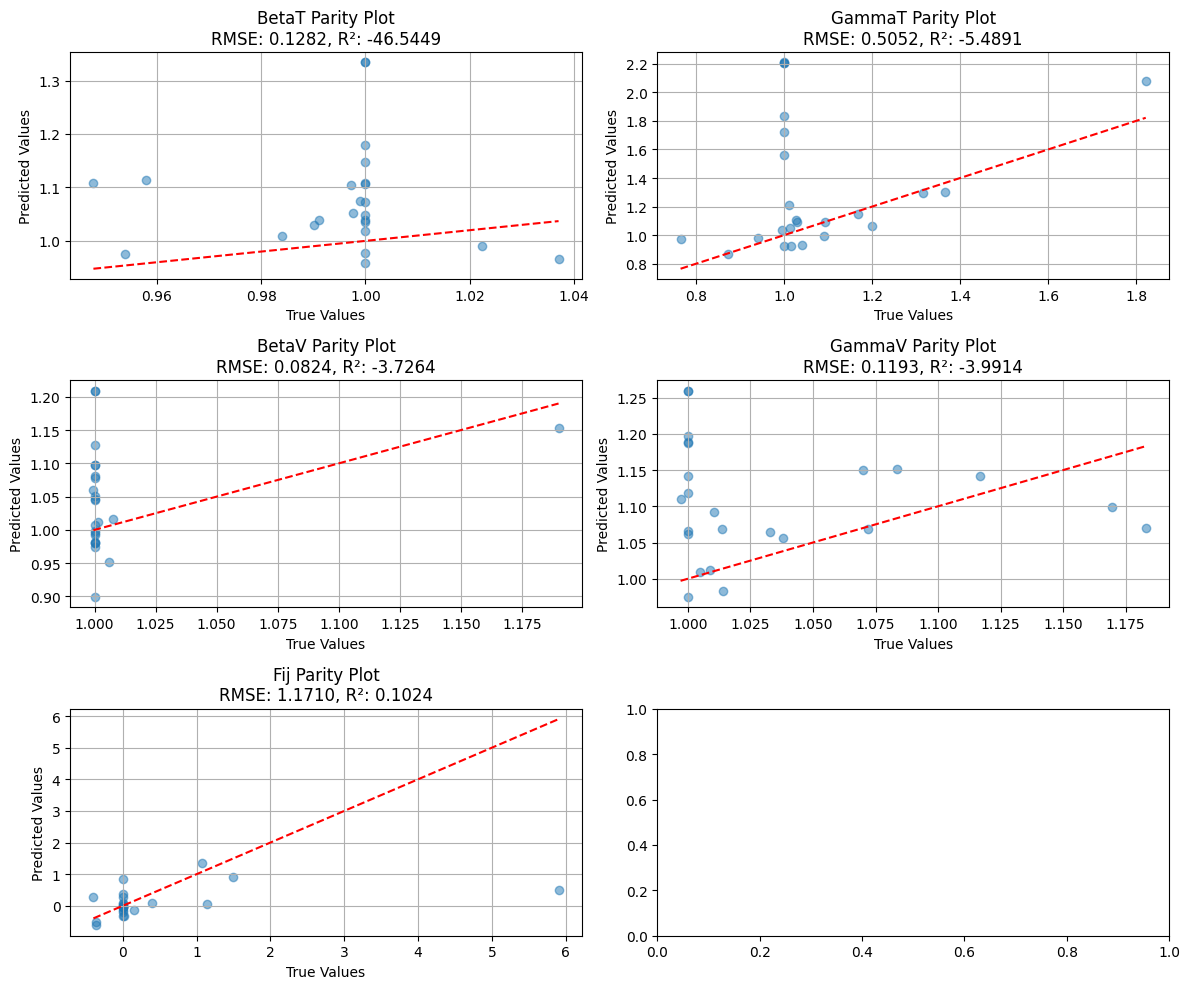

In [4]:
# Step 5: Test Evaluation with Parity Plots
model.eval()
test_targets = []
test_preds = []

with torch.no_grad():
    for smiles_pairs, targets in test_loader:
        predictions = model(smiles_pairs)
        test_targets.append(targets.cpu().numpy())
        test_preds.append(predictions.cpu().numpy())

test_targets = np.concatenate(test_targets, axis=0)
test_preds = np.concatenate(test_preds, axis=0)

# Plot Parity Plots for each target
target_labels = ['BetaT', 'GammaT', 'BetaV', 'GammaV','Fij']
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(5):
    y_true = test_targets[:, i]
    y_pred = test_preds[:, i]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    axes[i].scatter(y_true, y_pred, alpha=0.5)
    axes[i].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Perfect line
    axes[i].set_xlabel("True Values")
    axes[i].set_ylabel("Predicted Values")
    axes[i].set_title(f"{target_labels[i]} Parity Plot\nRMSE: {rmse:.4f}, R²: {r2:.4f}")
    axes[i].grid()

plt.tight_layout()
plt.show()

BetaT - RMSE: 0.1282, R²: -46.5449
GammaT - RMSE: 0.5052, R²: -5.4891
BetaV - RMSE: 0.0824, R²: -3.7264
GammaV - RMSE: 0.1193, R²: -3.9914
Fij - RMSE: 1.1710, R²: 0.1024


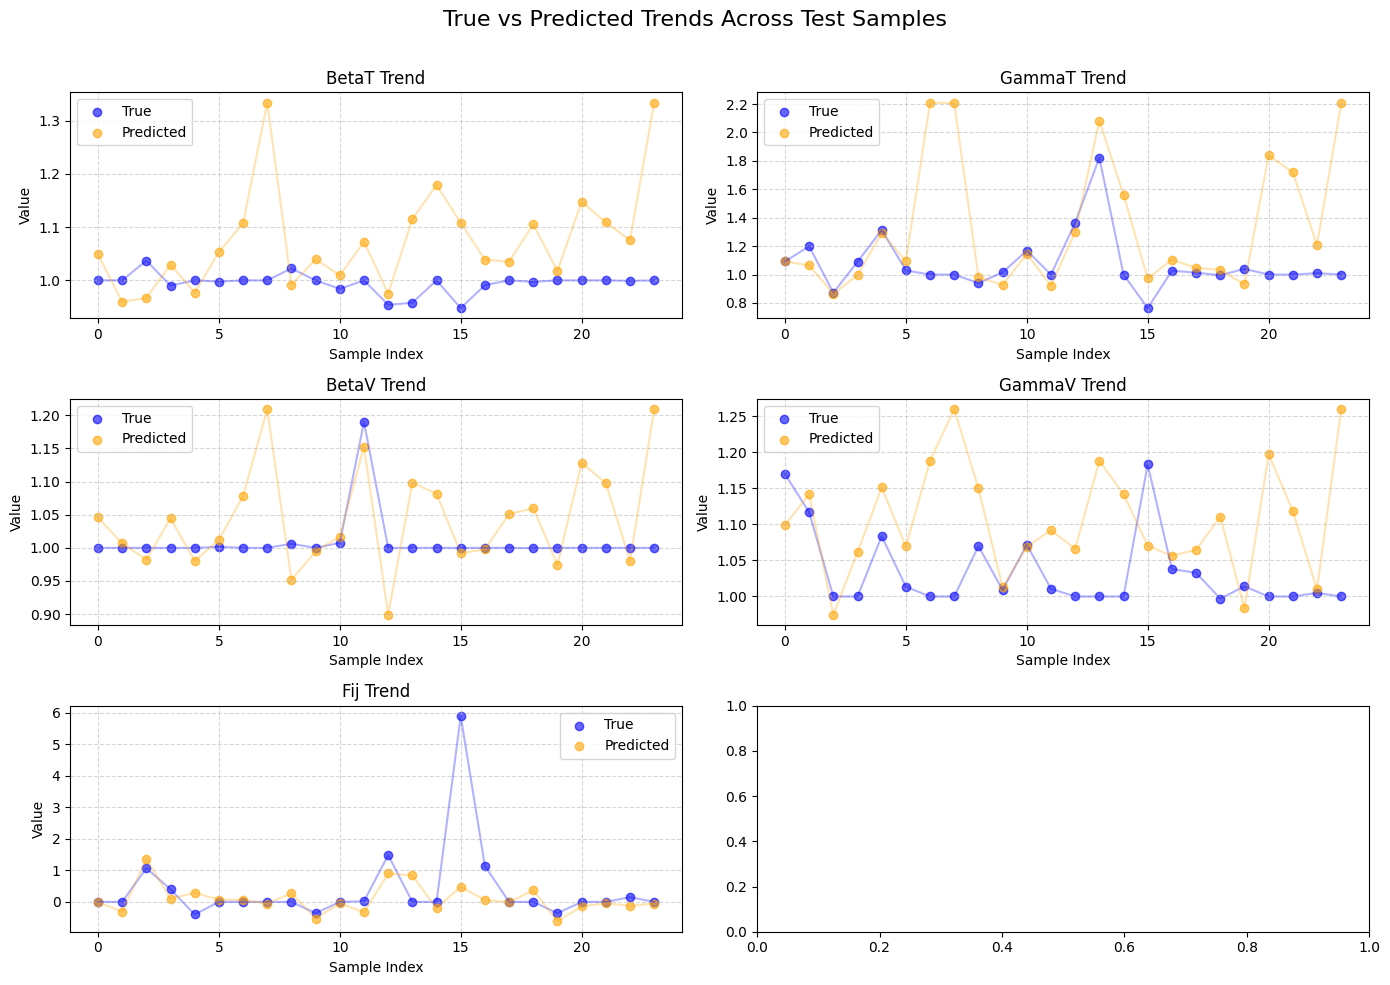

In [5]:
# Print Final Test Performance
for i in range(5):
    rmse = np.sqrt(mean_squared_error(test_targets[:, i], test_preds[:, i]))
    r2 = r2_score(test_targets[:, i], test_preds[:, i])
    print(f"{target_labels[i]} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Step 6: Trend Plot of True vs Predicted Values over Sample Index
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(5):
    y_true = test_targets[:, i]
    y_pred = test_preds[:, i]
    x = np.arange(len(y_true))  # Sample indices

    axes[i].scatter(x, y_true, color='blue', alpha=0.6, label='True')
    axes[i].scatter(x, y_pred, color='orange', alpha=0.6, label='Predicted')
    axes[i].plot(x, y_true, color='blue', alpha=0.3)
    axes[i].plot(x, y_pred, color='orange', alpha=0.3)

    axes[i].set_title(f'{target_labels[i]} Trend')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("True vs Predicted Trends Across Test Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
